# bias tests

i really want this idea of compression to encode sentiment analysis to work, because i like the idea of compression beign a synonym for intelligence.
i feel like i understand two ways in which the idea of using compression to encode sentiment analysis would work:

1. inherent speech patterns in sentiment (maybe we are more verbose or repetitive in one)
2. texts of similar sentiment will have similar words, and compression is good at measuring redundancy/repeating patterns

(1.) is not very interesting and we want to eliminate the possibility that it is a contributing factor

to account for (1.), we will investigate some things:

- lengths of positive vs negative texts
- lengths of compressed positive vs negative texts
- ratio of compression for each

then we do some benchmark measures for classification:
the dataset is balanced, meaning that if we classify randomly, we should get 50% accuracy. but what accuracy do we get when taking into account the length of the input? and what about the length of the compressed input?

In [1]:
import pickle
import gzip
import matplotlib.pyplot as plt

In [89]:
N_SAMPLES = 10000 

with open(f"sentiment-dataset-{N_SAMPLES}.pickle", "rb") as f:
    dataset = pickle.load(f)

train_x, train_y, test_x, test_y = dataset # samples are text strings (x) and sentiment -1 or 1 (y)

In [90]:
all_x = np.array([*train_x, *test_x])
all_y = np.array([*train_y, *test_y])

all_x_positive = all_x[all_y == 1]
all_x_negative = all_x[all_y == -1]

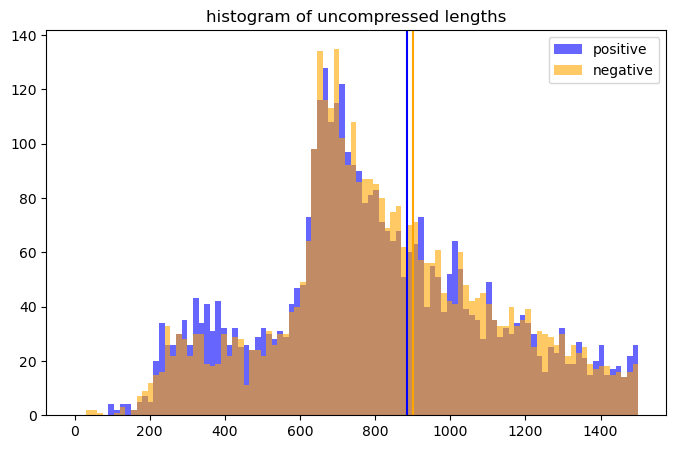

average positive length: 1214.1369726054788
average negative length: 1203.0371925614877
average positive median: 884.0
average negative median: 900.0


In [91]:
# calc just the length of each value in train_x to a new var called train_x_len
all_x_positive_len = [len(x) for x in all_x_positive]
all_x_negative_len = [len(x) for x in all_x_negative]

# plot the lengths:
fig = plt.figure(figsize=(8, 5))
plt.hist(all_x_positive_len, bins=100, range=(0, 1500), alpha=.6, label='positive', color=['blue'])
plt.axvline(x=np.median(all_x_positive_len), color='blue')
plt.hist(all_x_negative_len, bins=100, range=(0, 1500), alpha=.6, label='negative', color=['orange'])
plt.axvline(x=np.median(all_x_negative_len), color='orange')
plt.legend(loc='best')
plt.title('histogram of uncompressed lengths')
plt.show()

print('average positive length:', np.average(all_x_positive_len))
print('average negative length:', np.average(all_x_negative_len))

print('average positive median:', np.median(all_x_positive_len))
print('average negative median:', np.median(all_x_negative_len))

so, we can see that they are very similar both in histogram and length.
from now on, we will consider that this is not an important factor (but maybe it can explain accuracy gains under 1%)

we can confirm this by computing the accuracy of a classifier that uses purely the median values of each class:

In [92]:
avg_medians = (np.median(all_x_positive_len) + np.median(all_x_negative_len)) / 2
print(f'accuracy of median-based classifier: '
      f'{(np.sum([all_x_positive_len < avg_medians]) + np.sum([all_x_negative_len > avg_medians])) / 10000:.4f}')

accuracy of median-based classifier: 0.5075



now, we do the same for the compressed lengths

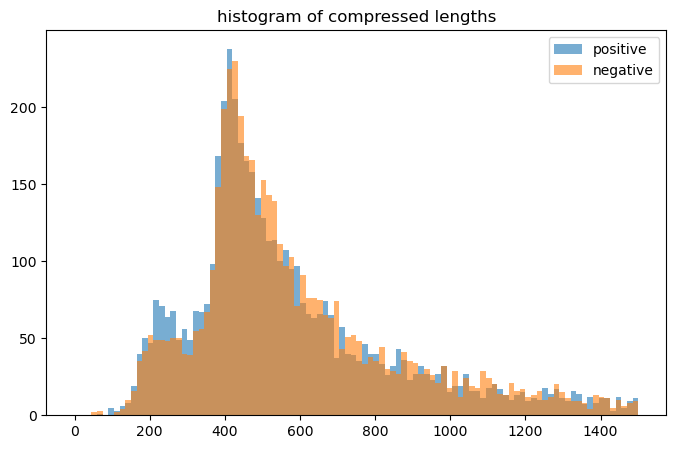

average positive length: 663.8074385122975
average negative length: 662.1969606078784


In [93]:
# calc just the length of each value in train_x to a new var called train_x_len
all_x_positive_compressed_len = [len(gzip.compress((x+' ').encode())) for x in all_x_positive]
all_x_negative_compressed_len = [len(gzip.compress((x+' ').encode())) for x in all_x_negative]

# plot the lengths:
fig = plt.figure(figsize=(8, 5))
plt.hist(all_x_positive_compressed_len, bins=100, range=(0, 1500), alpha=.6, label='positive')
plt.hist(all_x_negative_compressed_len, bins=100, range=(0, 1500), alpha=.6, label='negative')
plt.legend(loc='best')
plt.title('histogram of compressed lengths')
plt.show()

print('average positive length:', np.average(all_x_positive_compressed_len))
print('average negative length:', np.average(all_x_negative_compressed_len))

here we see there is almost no difference in the compressed length.

In [94]:
avg_compressed_medians = (np.median(all_x_positive_compressed_len) + np.median(all_x_negative_compressed_len)) / 2
print(f'accuracy of median-based classifier: '
      f'{(np.sum([all_x_positive_compressed_len < avg_compressed_medians]) + np.sum([all_x_negative_compressed_len > avg_compressed_medians])) / 10000:.4f}')

accuracy of median-based classifier: 0.5109


so this can confirm that length of texts alone can account for 1% of model accuracy. 

In [95]:
positive_compression_ratio = np.average(all_x_positive_len) / np.average(all_x_positive_compressed_len)
negative_compression_ratio = np.average(all_x_negative_len) / np.average(all_x_negative_compressed_len)
print(f'average positive compression ratio: {positive_compression_ratio:.3f}')
print(f'average negative compression ratio: {negative_compression_ratio:.3f}')

print(f'(positive/negative) compression: {positive_compression_ratio / negative_compression_ratio:.3f}')

average positive compression ratio: 1.829
average negative compression ratio: 1.817
(positive/negative) compression: 1.007


the compression ratios between positive and negative sentiment is roughly equal. this indicates that, at least for gzip compression, one is not more redundant or repetitive than the other.